# Income Tax Analysis NY

Global Definitions

In [37]:
%matplotlib inline
# %matplotlib notebook
from matplotlib import pyplot as plt

COL_TARGET = "Taxes Paid"
COL_TAX_YEAR = "Tax Year"
COL_CARDINALITY = "Number of Returns"
COL_COUNTRY = "Country"
COL_RESIDENCE = "Place of Residence"
COLS_TO_DROP = ["Sort on Place", "Sort on Income Range", "Notes"]
COLS_CATEGORICAL = ["NYS Residency Status", COL_RESIDENCE, "County", "State", COL_COUNTRY,
                    "NY Adjusted Gross Income Range (Fed.Col)"]
CSV_FILE = "personal-income-tax-filers-summary-dataset-2-major-items-and-income-deduction-components-by-place-of-1.csv"

COLS_MONETARY = [
    # 'Federal Amount of NY Adjusted Gross Income',
    #              'New York State Amount of NY Adjusted Gross Income',
    #              'New York Standard Deductions Claimed',
    #              'New York Itemized Deductions Claimed', 'Deductions Used',
    #              'Dependent Exemptions Claimed', 'Dependent Exemptions Used',
    #              'Taxable Income', 'Tax Before Credits',
    'Taxable Income',
    'Tax Liability',  # the payment owed by an entity to a federal, state, or local tax authority
    'Tax Credits',  # money that taxpayers can subtract directly from the taxes they owe
    'Wage and Salary Income',
    #              'Interest', 'Dividends',
    #              'Gain from Capital&Supplemental Income',
    #              'Loss from Capital&Supplemental Income',
    #              'Gain from Rent,Royalties,Prtnrshp,Estates,Trusts Income',
    #              'Loss from Rent,Royalties,Prtnrshp,Estates,Trusts Income',
    #              'Gain from Business & Farm Income', 'Loss from Business & Farm Income',
    #              'Pension/Annuity & IRA Income', 'All Other Income',
    #              'Federal Adjustments', 'Federal Adjusted Gross Income',
    #              'Additions State & Local Bond Interest',
    #              'Additions Public Employee Retirement System Contributions',
    #              'Additions College Choice Tuition Savings Program Distributions',
    #              'Other NY Additions', 'Subtractions State & Local Income Tax Refunds',
    #              'Subtractions Government Pension Exclusion',
    #              'Subtractions Taxable Social Security Income',
    #              'Subtractions Federal Bond Interest',
    #              'Subtractions Pension & Annuity Exclusion',
    #              'Subtractions College Choice Tuition Savings Program Deductions/Earnings',
    #              'Other NY Subtractions',
    'Medical & Dental Expenses',
    COL_TARGET,
    #              'Interest Paid', 'Charitable Contributions', 'Other Deductions',
    #              'Federal Deductions', 'Income Taxes & Subtraction Adjustments',
    #              'NY Addition Adjustments', 'NY Itemized Deduction Adjustment'
]

COLS = ['Tax Year', 'NYS Residency Status', 'Place of Residence', 'County',
        'State', 'Country', 'NY Adjusted Gross Income Range (Fed.Col)',
        'Number of Returns', 'Federal Amount of NY Adjusted Gross Income',
        'New York State Amount of NY Adjusted Gross Income',
        'New York Standard Deductions Claimed',
        'New York Itemized Deductions Claimed', 'Deductions Used',
        'Dependent Exemptions Claimed', 'Dependent Exemptions Used',
        'Taxable Income', 'Tax Before Credits', 'Tax Credits', 'Tax Liability',
        'Wage and Salary Income', 'Interest', 'Dividends',
        'Gain from Capital&Supplemental Income',
        'Loss from Capital&Supplemental Income',
        'Gain from Rent,Royalties,Prtnrshp,Estates,Trusts Income',
        'Loss from Rent,Royalties,Prtnrshp,Estates,Trusts Income',
        'Gain from Business & Farm Income', 'Loss from Business & Farm Income',
        'Pension/Annuity & IRA Income', 'All Other Income',
        'Federal Adjustments', 'Federal Adjusted Gross Income',
        'Additions State & Local Bond Interest',
        'Additions Public Employee Retirement System Contributions',
        'Additions College Choice Tuition Savings Program Distributions',
        'Other NY Additions', 'Subtractions State & Local Income Tax Refunds',
        'Subtractions Government Pension Exclusion',
        'Subtractions Taxable Social Security Income',
        'Subtractions Federal Bond Interest',
        'Subtractions Pension & Annuity Exclusion',
        'Subtractions College Choice Tuition Savings Program Deductions/Earnings',
        'Other NY Subtractions', 'Medical & Dental Expenses', 'Taxes Paid',
        'Interest Paid', 'Charitable Contributions', 'Other Deductions',
        'Federal Deductions', 'Income Taxes & Subtraction Adjustments',
        'NY Addition Adjustments', 'NY Itemized Deduction Adjustment']


Data Preprocessing

In [38]:
import math
import pandas as pd


def drop_rows_w_missing_values(df):
    nr_samples = len(df)
    df = df.dropna(axis="index", how="any")
    nr_samples_ = len(df)
    print(f"dropped {nr_samples - nr_samples_} samples with any missing values...")
    return df


path = CSV_FILE
df = pd.read_csv(path)
df.drop(columns=COLS_TO_DROP, inplace=True)
df[COL_TAX_YEAR] = df[COL_TAX_YEAR].astype(int)
df.fillna(0.0, inplace=True)

# Note: drop rows from aggregated columns
# TODO more exist:
print("existing categories:")
for c in COLS_CATEGORICAL:
    df = df[df[c].apply(lambda cat: not "all" in cat.lower())]
    print(c, df[c].unique())

for c in COLS_MONETARY:
    # average -> per person
    df[c] = df[c] / df[COL_CARDINALITY]
    # logarithm
    # TODO custom scaler into pipeline
    # Note: log(0) is undefined, so we add 1 to avoid this
    # Note no values in the range [0, 1] (mapped to negative logarithms)
    # Note: map negative values to negative logarithms
    df[c] = df[c].apply(lambda x: math.log(x + 1, 10) if x >= 0.0 else -math.log(-x, 10))

# TODO where do missing values come from?
df = drop_rows_w_missing_values(df)

# TODO only predict for people who pay taxes -> easier prediction, data less skewed
df = df[df[COL_TARGET] > 0.0]

print("done.")
print(f"found {len(df)} rows, {len(df.columns)} columns\n")




existing categories:
NYS Residency Status ['Full-Year Resident' 'Full-Year Nonresident' 'Part-Year Resident']
Place of Residence ['New York City - Bronx' 'New York City - Kings'
 'New York City - Manhattan' 'New York City - Queens'
 'New York City - Richmond' 'Albany' 'Broome' 'Cattaraugus' 'Cayuga'
 'Chautauqua' 'Chemung' 'Chenango' 'Clinton' 'Columbia' 'Cortland'
 'Delaware' 'Dutchess' 'Erie' 'Essex' 'Franklin' 'Fulton' 'Genesee'
 'Greene' 'Hamilton' 'Herkimer' 'Jefferson' 'Lewis' 'Livingston' 'Madison'
 'Monroe' 'Montgomery' 'Nassau' 'Niagara' 'Oneida' 'Onondaga' 'Ontario'
 'Orange' 'Orleans' 'Oswego' 'Otsego' 'Putnam' 'Rensselaer' 'Rockland'
 'St. Lawrence' 'Saratoga' 'Schenectady' 'Schoharie' 'Schuyler' 'Seneca'
 'Steuben' 'Suffolk' 'Sullivan' 'Tioga' 'Tompkins' 'Ulster' 'Warren'
 'Washington' 'Wayne' 'Westchester' 'Wyoming' 'Yates'
 'Other Places- NYS Resident' 'Alabama' 'Alaska' 'Arizona' 'Arkansas'
 'California' 'Colorado' 'Connecticut' 'Dtrct Of Columbia' 'Florida'
 'Georgia' 

import ydata_profiling

profile = ydata_profiling.ProfileReport(df,
                                        minimal=True
                                        )
profile.to_file("data_distribution_report.html")

In [39]:
import umap
import seaborn as sns

DIM_COLS = [f"dim{i}" for i in [1, 2]]


def reduce_dimensionality(X, nr_dims: int, **h_params):
    print(f"UMAP {h_params=}")
    print(f"reducing dimensionality from {X.shape[1]} to {nr_dims}... ")
    dim_reducer = umap.UMAP(n_components=nr_dims, metric="euclidean", **h_params)
    X_reduced = dim_reducer.fit_transform(X).T
    print("done.")
    return X_reduced


def add_umap_cols(df, columns, **h_params):
    embeddings = df[columns].values
    nr_dims = 2
    umap_embds = reduce_dimensionality(embeddings, nr_dims=nr_dims, **h_params)
    for d, umap_emb in enumerate(umap_embds):
        df[DIM_COLS[d]] = umap_emb


# TODO tune
params = dict(n_neighbors=5, min_dist=0.3)
# df_sample = df.sample(1000)
df_sample = df.copy()
add_umap_cols(df_sample, COLS_MONETARY, **params)

UMAP h_params={'n_neighbors': 5, 'min_dist': 0.3}
reducing dimensionality from 6 to 2... 
done.


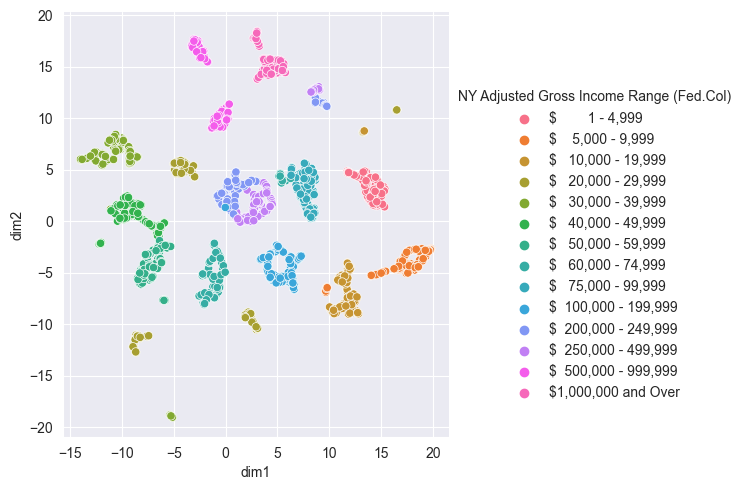

In [40]:
# category_column =COL_COUNTRY
# category_column =COL_RESIDENCE
# category_column = "NYS Residency Status"
# category_column = "County"
# category_column = "State"
category_column = "NY Adjusted Gross Income Range (Fed.Col)"
# COLS_CATEGORICAL = ["NYS Residency Status", COL_RESIDENCE, "County", "State", COL_COUNTRY,
#                     "NY Adjusted Gross Income Range (Fed.Col)"]
sns.relplot(data=df_sample, x=DIM_COLS[0], y=DIM_COLS[1], hue=category_column)  # s=size, **kwargs)

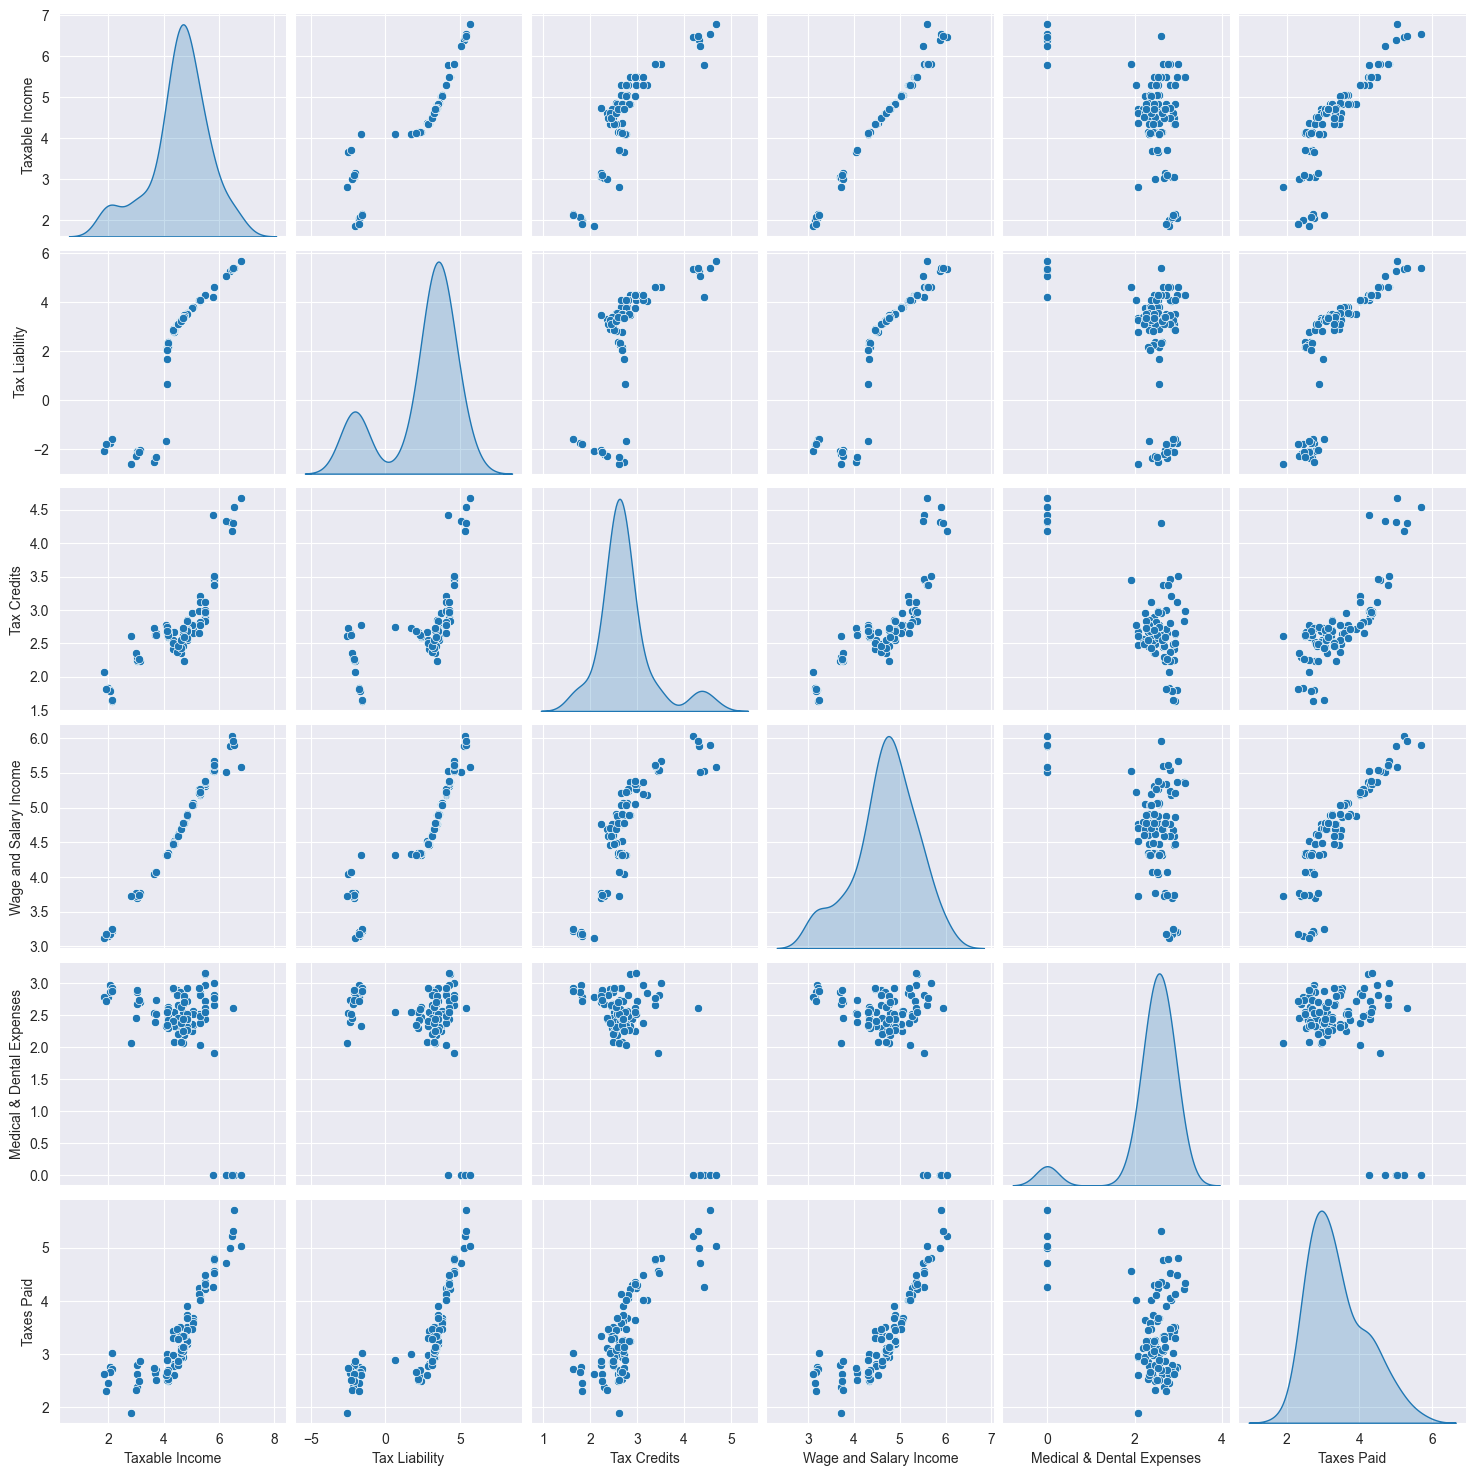

In [41]:
import seaborn as sns

sns.pairplot(df[COLS_MONETARY].sample(100), diag_kind='kde')

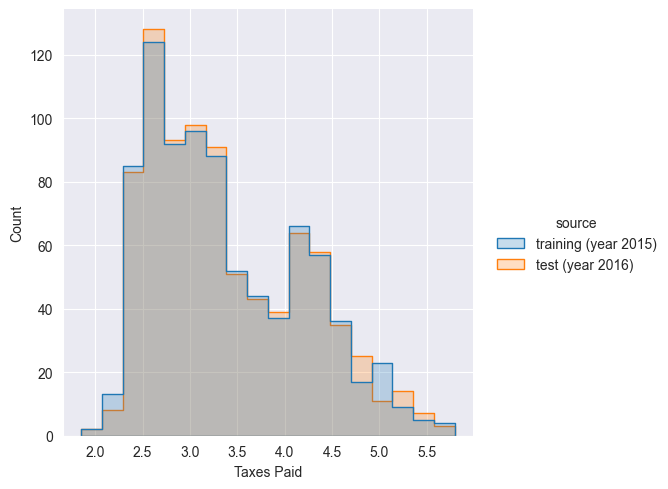

In [42]:
COL_SOURCE = "source"

# split based on year
COLS_INPUT = list(set(COLS_MONETARY) - {COL_TARGET})
X_train = df[df[COL_TAX_YEAR] == 2015]
X_test = df[df[COL_TAX_YEAR] == 2016]
y_train = X_train[COL_TARGET]
y_test = X_test[COL_TARGET]
X_train = X_train[COLS_INPUT]
X_test = X_test[COLS_INPUT]

# visualize distribution of target variable (train vs. test)
outputs1 = pd.DataFrame({COL_TARGET: y_train, COL_SOURCE: "training (year 2015)"})
outputs2 = pd.DataFrame({COL_TARGET: y_test, COL_SOURCE: "test (year 2016)"})
outputs = pd.concat([outputs1, outputs2])

sns.displot(outputs, x=COL_TARGET, hue=COL_SOURCE, element="step")

import skorch
from torch import nn
from torch.nn import functional as F


class TorchMLPRegressor(nn.Module):
    """
    Multilayer Perceptron for regression

    includes dropout and batch normalization
    """

    def __init__(
            self,
            layer_sizes: tuple[int],
            dropout: float = 0.5,
            activation_fct=F.relu,
            input_dim: int = 1,
    ):
        super().__init__()
        self.activation_fct = activation_fct
        assert len(layer_sizes) >= 1, f"layer_sizes must end with the output size, got {layer_sizes}"
        layer_sizes = input_dim, *layer_sizes
        nr_hidden_layers = len(layer_sizes) - 2
        layers = []
        for i in range(nr_hidden_layers):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            # Batch Normalization Layer after
            layers.append(nn.BatchNorm1d(layer_sizes[i + 1]))
            layers.append(self.activation_fct())
            # dropout is applied after activation layer
            layers.append(nn.Dropout(p=dropout))

        # last output layer without batch norm and dropout
        # regression: no output activation function (nonlinearity)
        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))
        self.nn = nn.Sequential(*layers)
        # TODO
        self.double()  # for compatibility with numpy float64 default dtype

    #         self.float()

    def forward(self, x):
        # TODO
        # x = x.to(torch.float32)
        return self.nn(x)


class InputShapeSetter(skorch.callbacks.Callback):
    def on_train_begin(self, net, X, y):
        net.set_params(module__input_dim=X.shape[1])


# variable validation_fraction:
# SKORCH_VALID_FRACTION = validation_fraction

# match lr_policy:
#     case training_configs.INVSCALING_LR_POLCIY:
#         scheduler_kwargs = dict(gamma=lr_gamma)
#     case training_configs.COSINE_LR_POLCIY:
#         scheduler_kwargs = dict(T_max=lr_t_max)  # Maximum number of iterations
#     case training_configs.STEP_LR_POLICY:
#         scheduler_kwargs = dict(gamma=lr_gamma, step_size=lr_step_size)
#     case training_configs.LINEAR_LR_POLICY:
#         # scale the learning rate from lr to lr_end_factor*lr towards the end of training
#         scheduler_kwargs = dict(start_factor=1, end_factor=lr_end_factor, total_iters=max_epochs)
#     case _:
#         scheduler_kwargs = {}
# scheduler = LRScheduler(policy=lr_policies[lr_policy], monitor="valid_loss", **scheduler_kwargs)
kwargs = dict(
    module=TorchMLPRegressor,
    module__layer_sizes=[100, 1],
    # module__dropout=dropout,
    module__activation_fct=activation_fcts[activation],
    # optimizer=optimisers[optimiser],
    # dataset=TypedTensorDataset,
    # iterator_train__drop_last=True,  # prevent batch norm error when batch_size of last batch is 1
    # iterator_train__shuffle=True,
    # lr=learning_rate,
    # batch_size=batch_size,
    # criterion=loss_fcts[loss],
    # train_split=get_skorch_split,
    callbacks=[
        #     default EpochTimer, BatchScoring (for both training and validation datasets), and PrintLog
        #     scheduler,
        #     skorch.callbacks.EarlyStopping(
        #         patience=patience,
        #         threshold=opt_tolerance,
        #         threshold_mode="abs",
        #         lower_is_better=True,
        #         load_best=True,
        #         monitor="valid_loss",
        #     ),
        InputShapeSetter()  # dynamically set the input shape of the model
        #     # skorch.callbacks.ProgressBar(),
        #     # skorch.callbacks.Checkpoint(dirname=checkpoint_dir),
    ],
    # predict_nonlinearity=None,
    # warm_start=False,
    # max_epochs=max_epochs,
    # verbose=verbose,
    # device=torch_device,
)
# if optimiser in WEIGHT_DECAY_OPTIMISERS:
#     not all optimisers support weight decay
# kwargs.update(dict(optimizer__weight_decay=weight_decay))

regr = skorch.NeuralNetRegressor(**kwargs)
X, y = X_train.values, y_train.values
regr.fit(X, y)


In [43]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()
regr.fit(X_train, y_train)

# import joblib
# joblib.dump(regr, "model.joblib")

# TODO 'Sequential' object has no attribute 'score'
score = regr.score(X_test, y_test)
score

0.7865548598054242

In [56]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=500,
                    # hidden_layer_sizes=(100, 100, 100),
                    hidden_layer_sizes=(100, ),
                    )
regr.fit(X_train, y_train)

# import joblib
# joblib.dump(regr, "model.joblib")

# TODO 'Sequential' object has no attribute 'score'
score = regr.score(X_test, y_test)
score

0.9430527583852444

TensorFlow version: 2.12.0
1 GPUs Available:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_20 (Normaliza  (None, 5)                11        
 tion)                                                           
                                                                 
 dense_47 (Dense)            (None, 100)               600       
                                                                 
 dense_48 (Dense)            (None, 1)                 101       
                                                                 
Total params: 712
Trainable params: 701
Non-trainable params: 11
_________________________________________________________________
None
training...


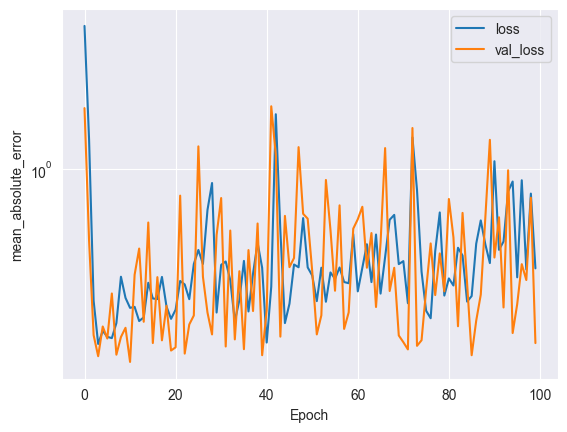

In [64]:
from keras import regularizers
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print(f"{len(tf.config.experimental.list_physical_devices('GPU'))} GPUs Available:")
# TODO use GPU
print(tf.config.list_physical_devices('GPU'))

from tensorflow import keras
from tensorflow.keras import layers

LOSS = 'mean_absolute_error'
# LOSS = 'mean_squared_error'
ACT_FCT = 'relu'
DROPOUT = 0.0
LAYER_SIZE = 100
NR_HIDDEN_LAYER = 1
WEIGHT_REGULARISER = None  # regularizers.l2(0.001)
ACTIVITY_REGULARIZER = None  # regularizers.l1(0.001)
batch_size = 128

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)


def build_and_compile_model(norm):
    layer_list = [norm, ]
    # layer_list = []

    for i in range(NR_HIDDEN_LAYER):
        layer_list += [
            layers.Dense(LAYER_SIZE, activation=ACT_FCT, kernel_regularizer=WEIGHT_REGULARISER,
                         activity_regularizer=ACTIVITY_REGULARIZER
                         ),
            layers.BatchNormalization(),
        ]
        if DROPOUT > 0.0:
            layer_list += [layers.Dropout(DROPOUT)]
    layer_list += [
        layers.Dense(1,
                     # activation='linear',
                     activation=ACT_FCT,
                     # kernel_regularizer=WEIGHT_REGULARISER,
                     # activity_regularizer=ACTIVITY_REGULARIZER,
                     ),
    ]  # target

    model = keras.Sequential(layer_list)

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=10000,
        decay_rate=0.9)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr_schedule,
        # learning_rate=0.001,
                                         )
    model.compile(loss=LOSS,
                  optimizer=optimizer, )
    return model


normalizer = tf.keras.layers.Normalization(axis=-1)

# fit the state of the preprocessing layer to the data by calling Normalization.adapt:
normalizer.adapt(X_train)

regr = build_and_compile_model(normalizer)
print(regr.summary())

print("training...")
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True,
                                            start_from_epoch=10)
# callbacks = [callback]
callbacks = []
history = regr.fit(
    X_train,
    y_train,

    validation_split=0.2,
    verbose=0,
    callbacks=callbacks,
    epochs=100,  #max
)


# regr.save('dnn_model')
# reloaded = tf.keras.models.load_model('dnn_model')
# results = dnn_model.evaluate(test_features, test_labels, verbose=0)


def plot_loss(history):
    # plt.cla()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel(LOSS)
    plt.semilogy()
    plt.legend()
    plt.grid(True)


plot_loss(history)

y_test_pred.shape (853,)
y_test.shape (853,)


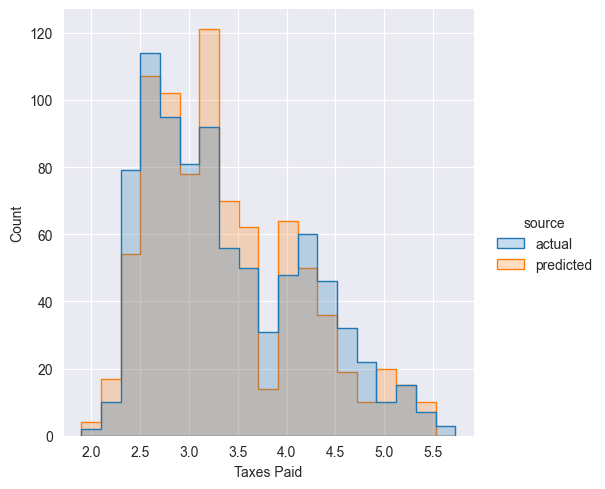

In [57]:
y_test_pred = regr.predict(X_test)

import seaborn as sns

y_test_pred = y_test_pred.flatten()
print("y_test_pred.shape", y_test_pred.shape)
print("y_test.shape", y_test.shape)
COL_SOURCE = "source"
outputs1 = pd.DataFrame({COL_TARGET: y_test, COL_SOURCE: "actual"})
outputs2 = pd.DataFrame({COL_TARGET: y_test_pred, COL_SOURCE: "predicted"})
outputs = pd.concat([outputs1, outputs2])
6
sns.displot(outputs, x=COL_TARGET, hue=COL_SOURCE, element="step")

y_train.shape=(850,)
y_train_pred.shape=(850,)


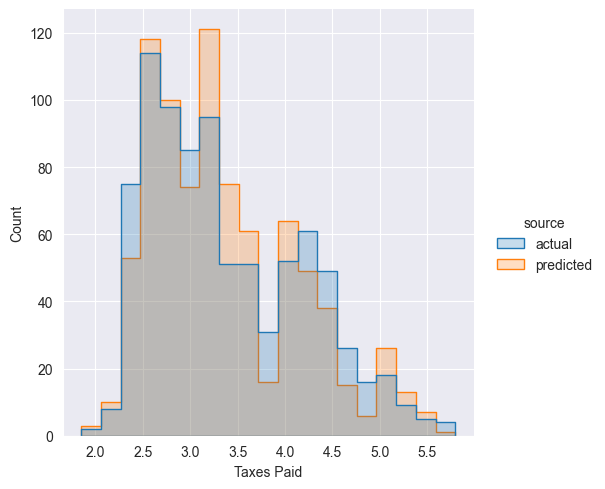

In [58]:
y_train_pred = regr.predict(X_train)

import seaborn as sns

y_train_pred = y_train_pred.flatten()
print(f"{y_train.shape=}")
print(f"{y_train_pred.shape=}")
COL_SOURCE = "source"
outputs1 = pd.DataFrame({COL_TARGET: y_train, COL_SOURCE: "actual"})
outputs2 = pd.DataFrame({COL_TARGET: y_train_pred, COL_SOURCE: "predicted"})
outputs = pd.concat([outputs1, outputs2])

sns.displot(outputs, x=COL_TARGET, hue=COL_SOURCE, element="step")

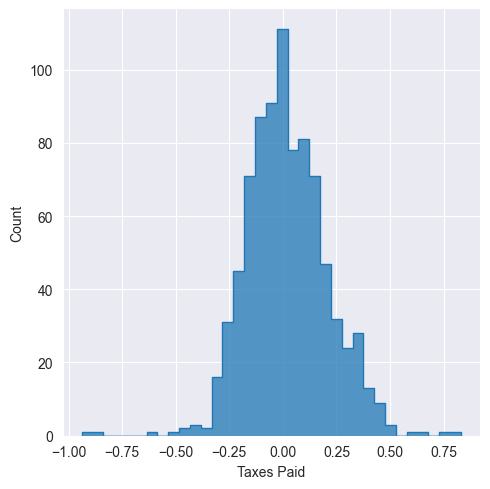

In [59]:
errors = y_test - y_test_pred
sns.displot(errors, element="step")